In [1]:
!pip install transformers

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast


# specify GPU
device = torch.device("cuda")

In [2]:
df = pd.read_csv("dataToPadding.csv")
df.head()

,Seri,Transcript,Sex,Age,PreprocessedContent,Label
0,s001,@UTF8\n@PID: 11312/t-00002184-1\n@Begin\n@Lang...,male,74,well theres a mother standing there uh uh wash...,0
1,s002,@UTF8\n@PID: 11312/t-00002185-1\n@Begin\n@Lang...,female,62,somebodys getting cookies outof the cookie jar...,0
2,s003,@UTF8\n@PID: 11312/t-00002192-1\n@Begin\n@Lang...,female,69,okay \ntheres a little boy and hes getting ...,0
3,s004,@UTF8\n@PID: 11312/t-00002194-1\n@Begin\n@Lang...,female,71,are you ready \num well the sink is overflow...,0
4,s005,@UTF8\n@PID: 11312/t-00002196-1\n@Begin\n@Lang...,female,74,okay \nmany dish or the mothers washing the...,0


In [3]:
train_text, val_text, train_labels, val_labels = train_test_split(df['PreprocessedContent'], df['Label'],
                                                                    random_state=20,
                                                                    test_size=0.3,
                                                                    stratify=df['Label'])


In [6]:
print(len(train_text))

75


AttributeError: Rectangle.set() got an unexpected keyword argument 'gridlines'

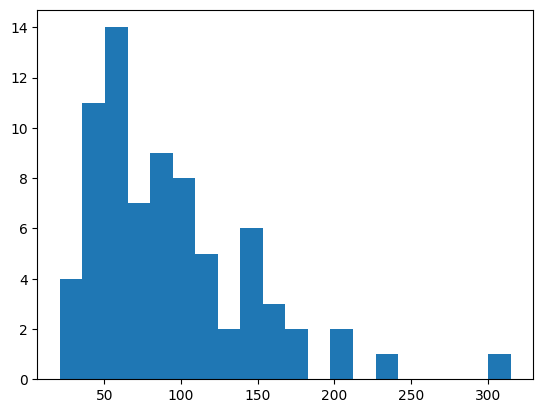

In [12]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 20, gridlines = None)

In [14]:
seq_len = [len(i.split()) for i in val_text]

pd.Series(len(seq_len))

,0
0,33


In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 500,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 500,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


In [ ]:
print(val_mask)

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 2

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
print(len(train_dataloader))

38


In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# pass the pre-trained BERT to our define architecture
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


In [ ]:

from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights


array([0.98684211, 1.01351351])

In [ ]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

epochs = 10

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


best_valid_loss = float('inf')

In [ ]:
print(len(train_dataloader))

In [ ]:
import time

def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 8 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    if step % 8 == 0 and not step == 0:

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [ ]:

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch     8  of     38.
  Batch    16  of     38.
  Batch    24  of     38.
  Batch    32  of     38.

Evaluating...
  Batch     8  of     17.
  Batch    16  of     17.

Training Loss: 0.702
Validation Loss: 0.686

 Epoch 2 / 10
  Batch     8  of     38.
  Batch    16  of     38.
  Batch    24  of     38.
  Batch    32  of     38.

Evaluating...
  Batch     8  of     17.
  Batch    16  of     17.

Training Loss: 0.677
Validation Loss: 0.679

 Epoch 3 / 10
  Batch     8  of     38.
  Batch    16  of     38.
  Batch    24  of     38.
  Batch    32  of     38.

Evaluating...
  Batch     8  of     17.
  Batch    16  of     17.

Training Loss: 0.596
Validation Loss: 0.544

 Epoch 4 / 10
  Batch     8  of     38.
  Batch    16  of     38.
  Batch    24  of     38.
  Batch    32  of     38.

Evaluating...
  Batch     8  of     17.
  Batch    16  of     17.

Training Loss: 0.369
Validation Loss: 0.402

 Epoch 5 / 10
  Batch     8  of     38.
  Batch    16  of     38.
  Batch  

In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [16]:
testDF = pd.read_csv('preprocessed_data2020.csv')

AttributeError: Rectangle.set() got an unexpected keyword argument 'gridlines'

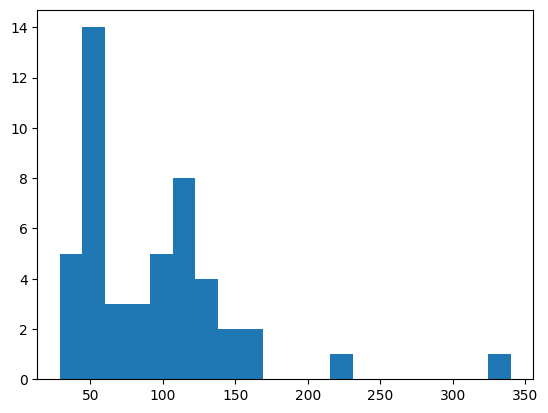

In [17]:
test_text = testDF['Preprocessed_Content']
test_label = testDF['label']
seq_len = [len(i.split()) for i in test_text]
pd.Series(seq_len).hist(bins = 20, gridlines = None)

# Print the shape of the extracted arrays
print("test_text shape:", test_text.shape)
print("test_label shape:", test_label.shape)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 500,
    pad_to_max_length=True,
    truncation=True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        24
           1       0.83      0.79      0.81        24

    accuracy                           0.81        48
   macro avg       0.81      0.81      0.81        48
weighted avg       0.81      0.81      0.81        48



In [ ]:
model = BERT_Arch(bert)

load_path = 'saved_weights.pt'
model.load_state_dict(torch.load(load_path))
model.eval()


BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
save_path = 'trained_model.pt'

torch.save(model.state_dict(), save_path)

print("Model saved at:", save_path)

Model saved at: trained_model.pt


In [ ]:
preds

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(test_label, preds)
print(cf_matrix)

[[20  4]
 [ 5 19]]


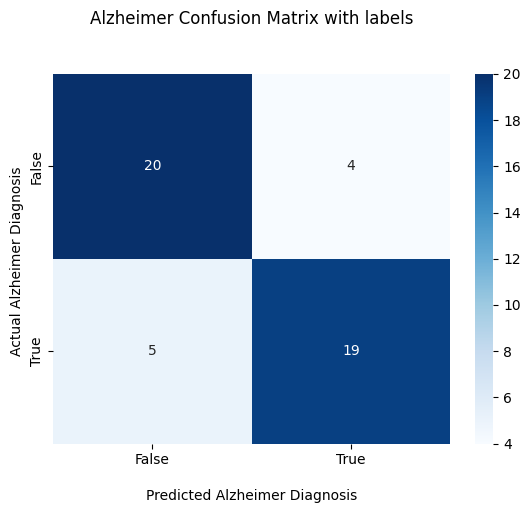

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Alzheimer Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Alzheimer Diagnosis')
ax.set_ylabel('Actual Alzheimer Diagnosis ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()